This use-case is based on [Kaggle's Rossmann Store Sales challenge](https://www.kaggle.com/c/rossmann-store-sales/overview), and the data is available also in the [course dataset collection](https://drive.google.com/drive/folders/1KQXg5CpZ8u59ybkvOnFPzo_WaLHxek_g?usp=sharing).

In [37]:
import pandas as pd
from datetime import datetime

# Get the data

In [38]:
path = '/content/drive/MyDrive/Data Science/Core materials/Datasets/Rossmann stores and sales'

## Sales

In [40]:
sales = pd.read_csv(path + '/train.csv')
sales.sample(5)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
785544,255,6,2013-07-27,5097,570,1,0,0,0
743182,263,2,2013-09-03,2106,227,1,0,0,1
83987,363,7,2015-05-17,0,0,0,0,0,0
16633,1024,5,2015-07-17,6197,771,1,1,0,0
884733,209,1,2013-04-29,6696,678,1,1,0,0


Thanks to the warning above we note that `StateHoliday` has inconsistent datatype.

In [41]:
print(sales.StateHoliday.unique())
d = {0: 'No', '0': 'No', 'a': 'Public', 'b': 'Easter', 'c': 'Christmas'}
sales.StateHoliday.replace(d, inplace=True)
print(sales.StateHoliday.unique())

['0' 'a' 'b' 'c' 0]
['No' 'Public' 'Easter' 'Christmas']


Next, we convert the `Date` column into a datetime column using `pd.to_datetime()`.

> **Note:** An alternative approach is to use the `parse_dates` argument in `read_csv()`.

In [42]:
sales.Date = pd.to_datetime(sales.Date)
sales = sales.set_index(['Store', 'Date']).sort_index()
sales.head()

DayOfWeek  Sales  ...  StateHoliday  SchoolHoliday
Store Date                          ...                             
1     2013-01-01          2      0  ...        Public              1
      2013-01-02          3   5530  ...            No              1
      2013-01-03          4   4327  ...            No              1
      2013-01-04          5   4486  ...            No              1
      2013-01-05          6   4997  ...            No              1

[5 rows x 7 columns]

Note that with `MultiIndex` we can select the data of a specific store by simply calling the first label, e.g.:

In [43]:
STORE = 2
sales.loc[STORE]

,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2013-01-01,2,0,0,0,0,Public,1
2013-01-02,3,4422,650,1,0,No,1
2013-01-03,4,4159,555,1,0,No,1
2013-01-04,5,4484,574,1,0,No,1
2013-01-05,6,2342,324,1,0,No,0
...,...,...,...,...,...,...,...
2015-07-27,1,6627,638,1,1,No,1
2015-07-28,2,5671,646,1,1,No,1
2015-07-29,3,6402,727,1,1,No,1


## Stores

In [44]:
stores = pd.read_csv(path + '/store.csv', index_col='Store')
stores.head()

,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Store,,,,,,,,,
1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


> **Thought:** Do these groups really reflect types of time serieses?

In [45]:
stores.groupby(['StoreType', 'Assortment']).apply(lambda df: df.index.values)

StoreType  Assortment
a          a             [2, 3, 5, 6, 8, 10, 14, 17, 22, 27, 28, 30, 32...
           c             [7, 9, 11, 12, 16, 19, 24, 33, 36, 42, 47, 51,...
b          a                           [85, 262, 335, 423, 494, 682, 1081]
           b                [259, 274, 353, 512, 676, 733, 769, 948, 1097]
           c                                                         [562]
c          a             [1, 25, 34, 37, 46, 91, 92, 114, 130, 131, 175...
           c             [4, 21, 63, 69, 70, 99, 141, 150, 203, 232, 25...
d          a             [13, 20, 23, 26, 38, 43, 45, 50, 66, 80, 100, ...
           c             [15, 18, 29, 31, 35, 41, 49, 52, 54, 56, 57, 6...
dtype: object

## Auxiliary visualization tools

In [50]:
def show_store_sales(store, start=None, end=None, col='Sales'):
    df = sales.loc[store]
    if not start:
        start = df.index.min()
    if not end:
        end = df.index.max()
    df[col].loc[start: end].plot(figsize=(10, 5), ls='-', marker='.')

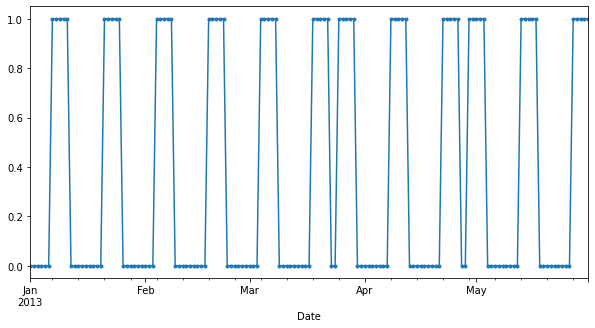

In [54]:
start = '2013-01-01'
end = '2013-5-31'
show_store_sales(store=29, start=start, end=end, col='Promo')

> **Note:** Many stores exhibit similar behaviours in terms of seasonality. As shown later, this is mainly due to `Promo`.

## Basic EDA

The data spans from 2013-01-01 to 2015-07-31.

In [55]:
print(sales.index.get_level_values(1).min())
print(sales.index.get_level_values(1).max())

2013-01-01 00:00:00
2015-07-31 00:00:00


> **Question:** Do all the stores have the same time frame?

There are 1115 stores in the data.

In [56]:
print(sales.index.get_level_values(0).nunique())
print(len(stores))

1115
1115


What about all the 0's in the `Sales` column? Do they all come from days when the store is closed?

In [57]:
sales.loc[(sales.Sales == 0) & (sales.Open==1)].head()

DayOfWeek  Sales  ...  StateHoliday  SchoolHoliday
Store Date                          ...                             
25    2014-02-12          3      0  ...            No              0
      2014-02-13          4      0  ...            No              0
28    2014-09-02          2      0  ...            No              1
      2014-09-03          3      0  ...            No              1
      2014-09-04          4      0  ...            No              0

[5 rows x 7 columns]

> **Thought:** What is the reason? It's very often consecutive days, so maybe the place is non-officially closed (e.g. under construction, health leave, etc.)

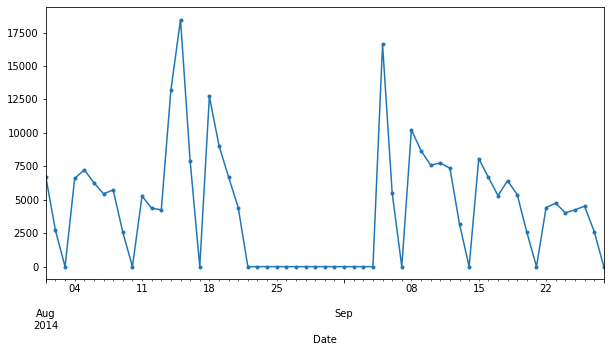

In [58]:
show_store_sales(store=28, start='2014-08-01', end='2014-09-28')
# show_store_sales(store=28, start='2014-08-01', end='2014-09-28', col='Open')

# Analyze a specific store

In [59]:
STORE = 2

In [60]:
my_store_data = sales.loc[STORE]
my_store_data.head()

,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2013-01-01,2,0,0,0,0,Public,1
2013-01-02,3,4422,650,1,0,No,1
2013-01-03,4,4159,555,1,0,No,1
2013-01-04,5,4484,574,1,0,No,1
2013-01-05,6,2342,324,1,0,No,0


## `DatetimeIndex`

The index of `my_store_data` is of the type [`DatetimeIndex`](https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html). 

> **Note:** It has a `dtype` and a `freq` attributes.

In [62]:
my_store_data.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-25',
               '2015-07-26', '2015-07-27', '2015-07-28', '2015-07-29',
               '2015-07-30', '2015-07-31'],
              dtype='datetime64[ns]', name='Date', length=942, freq=None)

We can specify datetime indexes with many ways.

In [65]:
start1 = my_store_data.index[3]
start2 = '2013-01-05'
start3 = datetime(2013, 1, 9)

end1 = my_store_data.index[10]
end2 = '2013-01-15'
end3 = datetime(2013, 1, 19)

my_store_data.loc[start1: end3]

,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2013-01-04,5,4484,574,1,0,No,1
2013-01-05,6,2342,324,1,0,No,0
2013-01-06,7,0,0,0,0,No,0
2013-01-07,1,6775,763,1,1,No,0
2013-01-08,2,6318,685,1,1,No,0
2013-01-09,3,6763,785,1,1,No,0
2013-01-10,4,5618,637,1,1,No,0
2013-01-11,5,4810,539,1,1,No,0
2013-01-12,6,2630,337,1,0,No,0


> **Further reading:** pandas supports various types of time-related objects. They are well documented in the corresponding chapter called [Time series / date functionality](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html). Specifically, the table at the beginning of the [overview](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#overview), gives a good survey of the main ones and they are related.

# Basic analyses

## Analysis 1

**What was the best week  and what was the best week-like?**

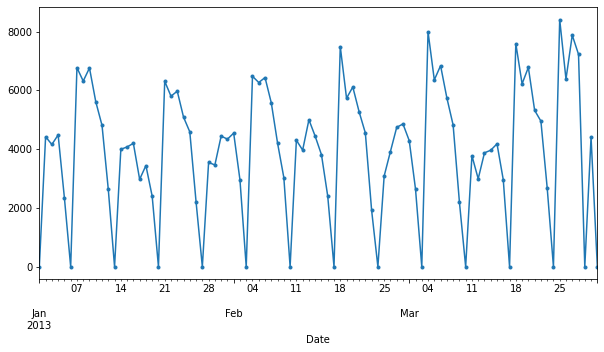

In [71]:
show_store_sales(store=2, start='2013-01-01', end='2013-03-31')

### `resample()`

([`resample()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.resample.html)) returns a `Resampler` object, which is an auxiliary grouper for time series. The main resampling argument is `rule`, which is a [`DateOffset`](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects).


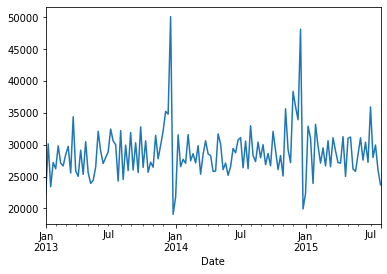

In [72]:
my_store_data.Sales.resample(rule='W-MON').sum().plot()

### `rolling()`

[`rolling()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html) applies a moving weighted **window** to the data.

In [75]:
my_store_data.Sales.rolling(window='7D').sum().plot();

Date
2013-01-01        0.0
2013-01-02     4422.0
2013-01-03     8581.0
2013-01-04    13065.0
2013-01-05    15407.0
               ...   
2015-07-27    26030.0
2015-07-28    27865.0
2015-07-29    29174.0
2015-07-30    30633.0
2015-07-31    32843.0
Name: Sales, Length: 942, dtype: float64

> **Note:** When using `window='W'` it returned an error.

## Analysis 2

**Which month showed the greatest jump in sales relative to its predecessor?**

### `shift()`

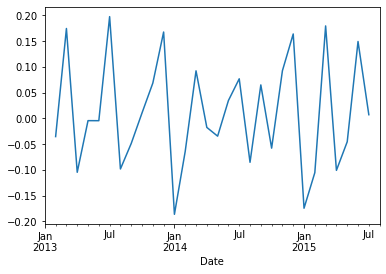

In [26]:
actual = my_store_data.Sales.resample('M').sum()
lagged = my_store_data.Sales.resample('M').sum().shift(periods=1, freq='M')
diffs = (actual - lagged) / lagged
diffs.plot()

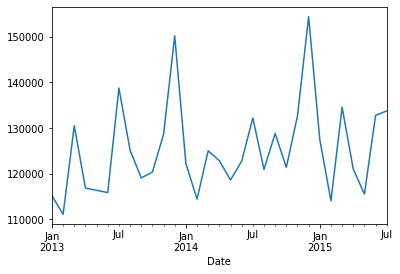

In [27]:
actual.plot()

In [28]:
diffs.idxmax()

Timestamp('2013-07-31 00:00:00', freq='M')

### `diff()`

> **Note:** This doesn't consider the ratios (unlike the previous example)

In [29]:
diffs = my_store_data.Sales.resample('M').sum().diff()

## Analysis 3

**Mark the outlier days**

> **Discussion:** What does it mean "outlier days"?
>
> (1) per store (2) per weekday (3) what about `Promo`?

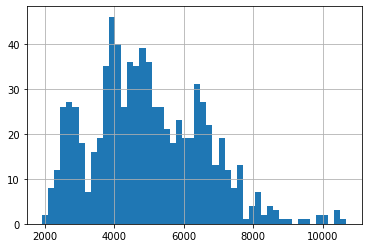

In [30]:
my_store_data.Sales.loc[my_store_data.Sales>0].hist(bins=50)

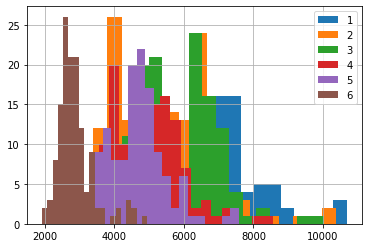

In [31]:
my_store_data.loc[my_store_data.Sales>0]\
    .groupby('DayOfWeek')['Sales'].hist(bins=20, alpha=1, legend=True);

In [32]:
def get_outliers(df, th=0.99):
    th_idx = int(th*len(df))
    return df.sort_values('Sales').iloc[th_idx:]

In [33]:
get_outliers(my_store_data)

,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2014-12-17,3,9365,909,1,1,No,0
2014-12-16,2,9499,866,1,1,No,0
2015-06-30,2,9863,877,1,1,No,0
2014-03-31,1,9908,963,1,1,No,0
2013-12-18,3,10019,1011,1,1,No,0
2015-03-31,2,10107,850,1,1,No,1
2013-12-17,2,10374,882,1,1,No,0
2014-12-15,1,10419,909,1,1,No,0
2013-12-16,1,10479,925,1,1,No,0


In [34]:
my_store_data.loc[my_store_data.Sales>0]\
    .groupby('DayOfWeek').apply(get_outliers, th=0.98)

DayOfWeek  Sales  ...  StateHoliday  SchoolHoliday
DayOfWeek Date                          ...                             
1         2014-12-15          1  10419  ...            No              0
          2013-12-16          1  10479  ...            No              0
          2014-06-30          1  10682  ...            No              0
2         2015-06-30          2   9863  ...            No              0
          2015-03-31          2  10107  ...            No              1
          2013-12-17          2  10374  ...            No              0
3         2013-07-31          3   8295  ...            No              1
          2014-12-17          3   9365  ...            No              0
          2013-12-18          3  10019  ...            No              0
4         2013-03-28          4   7229  ...            No              1
          2014-12-18          4   8117  ...            No              0
          2013-12-19          4   8559  ...            No              0
5         2014-05-02          5   7176  ...            No              1
          2013-12-20          5   7574  ...            No              0
          2014-12-19          5   7574  ...            No              0
6         2013-07-06          6   4504  ...            No              0
          2014-12-20          6   4553  ...            No              0
          2013-12-21          6   4941  ...            No              0

[18 rows x 7 columns]

> **Note:** The method [`apply(func)`](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.apply.html) can pass kwargs to `func`.

> **Discussion:** What should we do with the outliers? This depends on the goals of our analysis.

## Analysis 4

**Look for significant changes (due to `Promo`)**

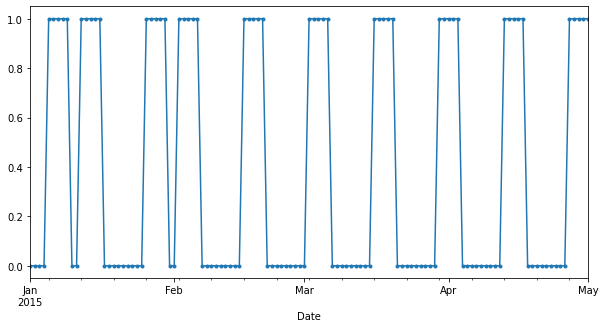

In [35]:
show_store_sales(store=2, start='2015-01-01', end='2015-05-01', col='Promo')

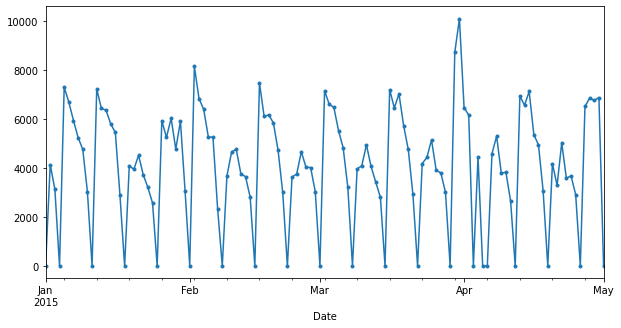

In [36]:
show_store_sales(store=2, start='2015-01-01', end='2015-05-01', col='Sales')

We see the bi-weekly influence, but we want to see the influence itself.

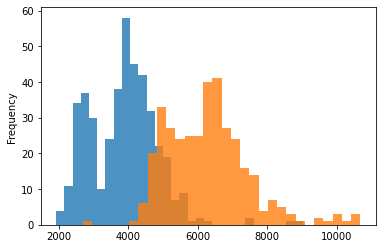

In [ ]:
my_store_data.loc[my_store_data.Open==1].groupby('Promo')['Sales'].plot.hist(bins=30, alpha=0.8);

> **TBC:** What is the influence of "days from start of promo"?
>
> **TBC2:** What is the influence of `Promo2`?

## Analysis 5

**Look for significant changes (due to competition)**

Let's find a store, whose competition started during 2014, and create comperative visualization.

In [ ]:
stores.loc[stores.CompetitionOpenSinceYear == 2014].sample(5)

,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Store,,,,,,,,,
970,a,a,910.0,12.0,2014.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct"
126,d,a,3370.0,10.0,2014.0,1,18.0,2011.0,"Feb,May,Aug,Nov"
449,a,c,120.0,12.0,2014.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct"
740,d,a,6400.0,3.0,2014.0,0,NaN,NaN,NaN
956,a,a,2330.0,10.0,2014.0,1,18.0,2011.0,"Feb,May,Aug,Nov"


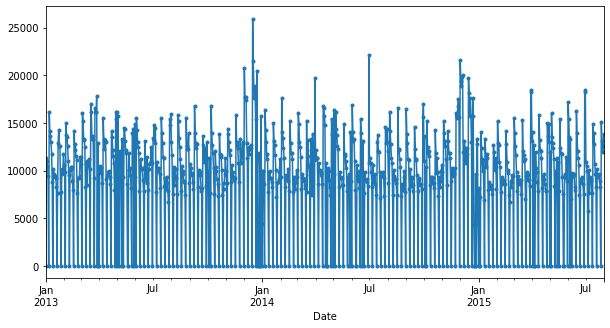

In [ ]:
STORE = 449

show_store_sales(store=STORE)

Competition started at 2014-12-28 00:00:00


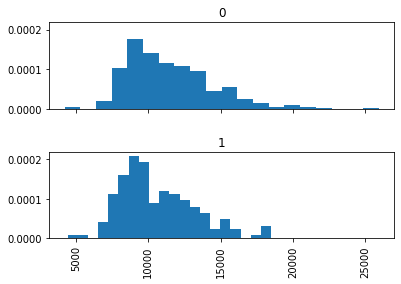

In [ ]:
y = int(stores.loc[STORE, 'CompetitionOpenSinceYear'])
m = int(stores.loc[STORE, 'CompetitionOpenSinceMonth'])
CompetitionOpenSinceDate = datetime(year=y, month=m, day=28)
print(f'Competition started at {CompetitionOpenSinceDate}')

my_store_data = sales.loc[STORE]
my_store_data = my_store_data.loc[my_store_data.Open == 1]
my_store_data['comp'] = (my_store_data.index > CompetitionOpenSinceDate).astype(int)

my_store_data.hist('Sales', bins=20, by='comp', 
                   sharex=True, sharey=True, 
                   density=True, layout=(2, 1));

# TBC

* Changes due to proximity to holidays
* differences between StoreType

In [ ]:
# you can fill values by:
#------------------------
#     backfill - .bfill()
#     nearest - .nearest()
#     forwardfill - .pad()

Time series data often requires cleaning, scaling, and even transformation.

__Frequency__. Perhaps data is provided at a frequency that is too high to model or is unevenly spaced through time requiring resampling for use in some models.

__Outliers__. Perhaps there are corrupt or extreme outlier values that need to be identified and handled.

__Missing__. Perhaps there are gaps or missing data that need to be interpolated or imputed